In [14]:
import gc
gc.collect()

28

In [1]:
import pandas as pd
import imageio
import glob
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
from copy import deepcopy
import json
import numpy as np
from skimage.transform import resize


In [2]:
train_data=np.load("train_image.npy")
#train_mask=np.load("train_mask.npy")
#test_data=np.load("test_image.npy")
#ground_truth=np.load("test_real_mask.npy")

# Pre-processing

In [3]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

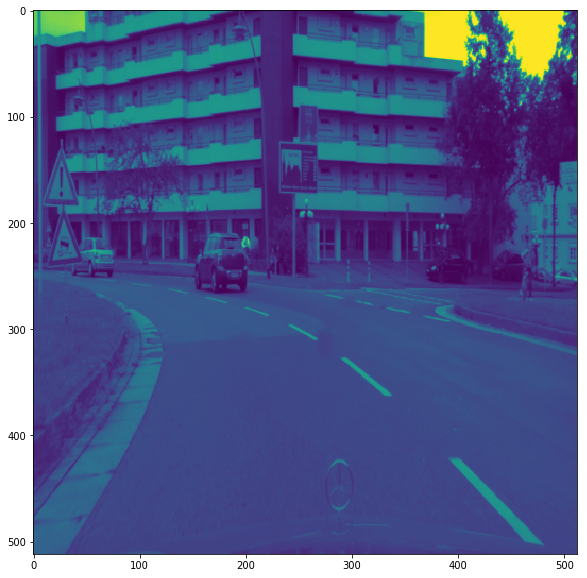

In [4]:
plt.imshow(train_data[0])

In [11]:
image_dir_path="/home/jupyter/dataset/image/train/"

In [12]:
image_dir= os.listdir(image_dir_path)

In [13]:
images_files = [f for f in glob.glob(image_dir_path + "**/*.png", recursive=True)]
print("number of mask file :::",len(images_files))

number of mask file ::: 2975


In [14]:
images_files.sort()

In [15]:
image_array_test=[]
for i in images_files:
        img=imageio.imread(i)
        image_array_test.append(resize(img,(512,512),preserve_range=True))

In [16]:
image_array_test=np.array(image_array_test)

MemoryError: Unable to allocate array with shape (2975, 512, 512, 3) and data type float64

In [ ]:
image_array_test = image_array_test.astype('float32')

In [ ]:
image_array_test = image_array_test - np.mean(image_array_test)
image_array_test = image_array_test / np.std(image_array_test)

In [ ]:
image_array_test.shape

In [11]:
np.save('/home/jupyter/code/mobile_net_array/test_image_512_3_channel',image_array_test)

In [17]:
train_mask=np.load("train_mask.npy")

In [8]:
#converting to float32
#train_data = train_data.astype('float32')
# image_array = image_array.astype('float32')
train_mask=train_mask.astype('float32')
# test_data=test_data.astype('float32')
#ground_truth=ground_truth.astype('float32')

In [13]:
#procesing test and train data(normalizing)
#train_data = train_data - np.mean(train_data)
#train_data = train_data / np.std(train_data)
test_data = test_data - np.mean(test_data)
test_data = test_data / np.std(test_data)

In [9]:
# normalizing the test and train mask
train_mask = train_mask/255
#ground_truth=ground_truth/255

In [15]:
#adding new axis to data and mask
def channel3(gray):
    temp=[]
    for image in gray:
        image=cv2.merge((image,image,image))
        temp.append(image)
    temp=np.array(temp)
    return temp

In [158]:
#train_data=channel3(train_data)
train_mask=channel3(train_mask_mobile)
#test_data=channel3(test_data)
#ground_truth=channel3(ground_truth)

In [49]:
#train_data=np.array(train_data)
train_mask=np.array(train_mask)
#test_data=np.array(test_data)
#ground_truth=np.array(ground_truth)

In [17]:
#np.save('/home/jupyter/code/mobile_net_array/train_data.npy',train_data_mobile)
np.save('/home/jupyter/code/mobile_net_array/train_mask.npy',train_mask_mobile)
#np.save('/home/jupyter/code/mobile_net_array/test_data.npy',test_data_mobile)
np.save('/home/jupyter/code/mobile_net_array/ground_truth.npy',ground_truth_mobile)

In [10]:
train_mask=train_mask[...,np.newaxis]

(2975, 512, 512)

In [12]:
train_data_mobile=[]
for image in train_data:
        train_data_mobile.append(resize(image,(224,224),preserve_range=True))
train_data_mobile=np.array(train_data_mobile)

In [51]:
train_mask_mobile=[]
for image in train_mask:
        train_mask_mobile.append(resize(image,(224,224),preserve_range=True))
train_mask_mobile=np.array(train_mask_mobile)

In [19]:
test_data_mobile=[]
for image in test_data:
        test_data_mobile.append(resize(image,(224,224),preserve_range=True))
test_data_mobile=np.array(test_data_mobile)

In [89]:
ground_truth_mobile=[]
for image in ground_truth:
        ground_truth_mobile.append(resize(image,(224,224),preserve_range=True))
ground_truth_mobile=np.array(ground_truth_mobile)

In [86]:
ground_truth=ground_truth[...,np.newaxis]

In [88]:
ground_truth.shape

(500, 512, 512, 1)

In [83]:
# loading array
#train_data_mobile=np.load('/home/jupyter/code/mobile_net_array/train_data.npy')
#train_mask_mobile=np.load('/home/jupyter/code/mobile_net_array/train_mask.npy')
#test_data_mobile=np.load('/home/jupyter/code/mobile_net_array/test_data.npy')
#ground_truth_mobile=np.load('/home/jupyter/code/mobile_net_array/ground_truth.npy')

# implementation of mobile net

In [23]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense,Activation,Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
import keras
import tensorflow as tf

In [25]:
base_model = MobileNetV2(include_top=False)

# calculating iou

In [161]:
# calculating iou
arr_iou=[]
for i in range(len(predicted_mask)):
    intersection = np.logical_and(ground_truth_mobile[i],predicted_mask[i])
    union = np.logical_or(ground_truth_mobile[i], predicted_mask[i])
    iou_score = np.sum(intersection) / np.sum(union)
    arr_iou.append(iou_score)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [162]:
arr_iou =np.array(arr_iou)

In [164]:
arr_iou= np.nan_to_num(arr_iou, copy=True, nan=1.0)

In [165]:
arr_iou.mean()

0.48548609618616406

In [54]:
arr_iou.mean()

0.5928453051208369

# mobilnet model

In [57]:
# # choosing trainable layer
# for layer in down_stack.layers[:50]:
#    layer.trainable = False
# for layer in down_stack.layers[50:]:
#    layer.trainable = True

In [26]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

In [27]:
layers

[<tf.Tensor 'block_1_expand_relu_1/Relu6:0' shape=(?, ?, ?, 96) dtype=float32>,
 <tf.Tensor 'block_3_expand_relu_1/Relu6:0' shape=(?, ?, ?, 144) dtype=float32>,
 <tf.Tensor 'block_6_expand_relu_1/Relu6:0' shape=(?, ?, ?, 192) dtype=float32>,
 <tf.Tensor 'block_13_expand_relu_1/Relu6:0' shape=(?, ?, ?, 576) dtype=float32>,
 <tf.Tensor 'block_16_project_1/convolution:0' shape=(?, ?, ?, 320) dtype=float32>]

In [28]:
down_stack = Model(inputs=base_model.input, outputs=layers)


In [122]:
#down_stack.trainable = False

In [39]:
def unet_model(output_channels):

  # This is the last layer of the model
  last = keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = keras.layers.Input(shape=[512, 512, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return keras.Model(inputs=inputs, outputs=x)

In [40]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = keras.Sequential()
  result.add(
    keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(keras.layers.Dropout(0.5))

  result.add(keras.layers.ReLU())

  return result

In [41]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [42]:
model=unet_model(3)

In [43]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
model.fit(image_array, train_mask, batch_size=8, epochs=50, verbose=1, shuffle=True)

Epoch 1/50
2975/2975 [==============================] - 193s 65ms/step - loss: 0.0387 - accuracy: 0.9622
Epoch 2/50
2975/2975 [==============================] - 196s 66ms/step - loss: 0.0374 - accuracy: 0.9625
Epoch 3/50
2975/2975 [==============================] - 197s 66ms/step - loss: 0.0340 - accuracy: 0.9636
Epoch 4/50
2975/2975 [==============================] - 196s 66ms/step - loss: 0.0321 - accuracy: 0.9642
Epoch 5/50
2975/2975 [==============================] - 196s 66ms/step - loss: 0.0316 - accuracy: 0.9645
Epoch 6/50
2975/2975 [==============================] - 196s 66ms/step - loss: 0.0341 - accuracy: 0.9636
Epoch 7/50
2975/2975 [==============================] - 196s 66ms/step - loss: 0.0328 - accuracy: 0.9640
Epoch 8/50
2975/2975 [==============================] - 197s 66ms/step - loss: 0.0319 - accuracy: 0.9643
Epoch 9/50
2975/2975 [==============================] - 197s 66ms/step - loss: 0.0413 - accuracy: 0.9613
Epoch 10/50
2975/2975 [==============================] 

KeyboardInterrupt: 

In [45]:
tes

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 multiple             1841984     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 32, 32, 512)  1476608     model_1[2][4]                    
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 32, 32, 1088) 0           sequential_5[1][0]               
                                                                 model_1[2][3]              

In [129]:
model.save('/home/jupyter/code/mobile_net_array/Mobile_vnet_model_new.h5')

In [117]:
from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
model = load_model('/home/jupyter/code/mobile_net_array/Mobile_vnet_model.h5')

In [68]:
prediction_mobile_v2=model.predict(image_array_test,verbose=1)

500/500 [==============================] - 17s 34ms/step


In [85]:
ground_truth.shape

(500, 512, 512)

In [72]:
# setting threshold
for image in pred_mobile_net:
    image[image<0.5]=0
    image[image>=0.5]=1

In [71]:
pred_mobile_net=[]
for image in prediction_mobile_v2:
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pred_mobile_net.append(image)

In [73]:
pred_mobile_net= np.array(pred_mobile_net)

In [74]:
pred_mobile_net=pred_mobile_net[...,np.newaxis]

In [77]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


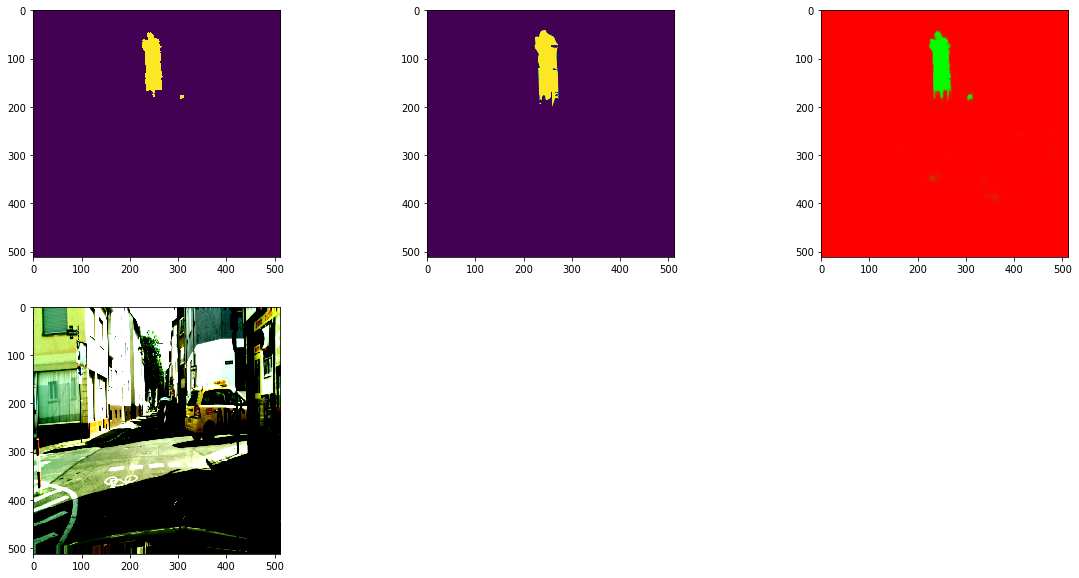

In [89]:
plt.subplot(2, 3, 1)
plt.imshow(np.squeeze(pred_mobile_net[0],axis=2))

plt.subplot(2, 3, 2)
plt.imshow(np.squeeze(ground_truth[0],axis=2))

plt.subplot(2, 3, 3)
plt.imshow(prediction_mobile_v2[0])

plt.subplot(2,3,4)
plt.imshow(image_array_test[0])

plt.show()

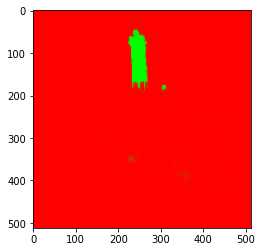

In [70]:
plt.imshow(prediction_mobile_v2[0])

In [91]:
arr_iou=[]
for i in range(len(pred_mobile_net)):
    intersection = np.logical_and(ground_truth[i],pred_mobile_net[i])
    union = np.logical_or(ground_truth[i], pred_mobile_net[i])
    iou_score = np.sum(intersection) / np.sum(union)
    arr_iou.append(iou_score)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [97]:
arr_iou= np.nan_to_num(arr_iou, copy=True, nan=0.0)

In [92]:
arr_iou=np.array(arr_iou)

In [110]:
arr_iou

array([0.5572666 , 0.43518952, 0.        , 0.76525468, 0.7454274 ,
       0.        , 0.65613504, 0.67207029, 0.63781378, 0.67132189,
       0.59018501, 0.26851717, 0.52276055, 0.59530516, 0.43591735,
       0.43776552, 0.46436652, 0.31776362, 0.51848617, 0.02991233,
       0.2992126 , 0.52816827, 0.52841174, 0.01392301, 0.33284187,
       0.6216864 , 0.60656483, 0.28198335, 0.16400669, 0.28952427,
       0.73684211, 0.02927581, 0.2452459 , 0.40907905, 0.39915452,
       0.62681461, 0.48607402, 0.4887362 , 0.5329027 , 0.55140187,
       0.6264194 , 0.61226037, 0.08971348, 0.63879447, 0.51535254,
       0.71629393, 0.04669887, 0.53854887, 0.66269611, 0.66818535,
       0.41808737, 0.24456233, 0.29015161, 0.        , 0.05450416,
       0.44809841, 0.17870339, 0.48834628, 0.51424972, 0.55637513,
       0.53433804, 0.47864495, 0.6026793 , 0.49678021, 0.08029648,
       0.52273064, 0.4848722 , 0.58771737, 0.56043401, 0.        ,
       0.65054294, 0.03512881, 0.        , 0.27768663, 0.45177

In [207]:
unet_output=np.load('predicted_mask.npy')

In [258]:
# setting threshold
for image in gt:
    image[image<0.45]=0
    image[image>=0.45]=1

In [260]:
arr_iou_unet=[]
inter=[]
u=[]
for i in range(len(unet_output)):
    intersection = np.logical_and(gt[i],unet_output[i])
    inter.append(np.sum(intersection))
    union = np.logical_or(gt[i], unet_output[i])
    u.append(np.sum(union))
    iou_score = np.sum(intersection) / np.sum(union)
    arr_iou_unet.append(iou_score)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [229]:
unet_output=unet_output[...,np.newaxis]

In [230]:
unet_output.shape

(500, 512, 512, 1)

In [232]:
gt=np.load('test_real_mask.npy')

In [234]:
gt=gt[...,np.newaxis]

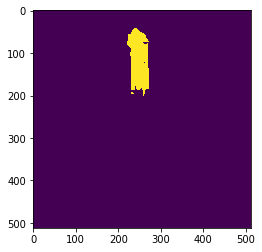

In [259]:
plt.imshow(np.squeeze(gt[0],axis=2))

In [261]:
arr_iou_unet= np.nan_to_num(arr_iou_unet, copy=True, nan=0.0)

In [262]:
arr_iou_unet.mean()

0.6837446595332995